<a href="https://colab.research.google.com/github/arnaldourbina/HACKATON_Equipo_H12-25-L-Equipo74/blob/main/Notebook_variables_explicativas_causas_de_retrasos_graves_flights2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**✈️CAUSAS DE RETRASOS GRAVES**

##**Estudiando los datos**

In [1]:
import pandas as pd
import polars as pl


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
datos = pd.read_parquet("/content/drive/MyDrive/HACKATHON/ARCHIVOS 2015/flights2015.parquet")

In [4]:
datos.to_parquet("/content/drive/MyDrive/HACKATHON/ARCHIVOS 2015/flights2015.parquet", engine="pyarrow", index=False)
# Guardar como Parquet


In [5]:
datos["ORIGIN_AIRPORT"] = datos["ORIGIN_AIRPORT"].astype(str) # Forzar columna a string

cols_airports = ["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"] # Forzar columnas de aeropuertos a texto

for col in cols_airports:
    datos[col] = datos[col].astype(str)




#**Diccionario de traducción de columnas**

In [6]:

columnas_es = {
    "YEAR": "AÑO",
    "MONTH": "MES",
    "DAY": "DÍA",
    "DAY_OF_WEEK": "DÍA_SEMANA",
    "AIRLINE":"AEROLÍNEA",
    "FLIGHT_NUMBER": "NÚMERO_VUELO",
    "TAIL_NUMBER":"NÚMERO_DEL_AVIÓN",
    "ORIGIN_AIRPORT":"AEROPUERTO_ORIGEN",
    "DESTINATION_AIRPORT":"AEROPUERTO_DESTINO",
    "SCHEDULED_DEPARTURE": "SALIDA_PROGRAMADA",
    "DEPARTURE_TIME": "HORA_SALIDA",
    "DEPARTURE_DELAY": "RETRASO_SALIDA",
    "TAXI_OUT": "RODAJE_SALIDA",
    "WHEELS_ON":"ATERRIZAJE",
    "TAXI_IN":"RODAJE_LLEGADA",
    "WHEELS_OFF": "DESPEGUE",
    "SCHEDULED_ARRIVAL": "LLEGADA_PROGRAMADA",
    "ARRIVAL_TIME": "HORA_LLEGADA",
    "ARRIVAL_DELAY": "RETRASO_LLEGADA",
    "DIVERTED": "DESVIADO",
    "CANCELLED": "CANCELADO",
    "AIR_SYSTEM_DELAY": "RETRASO_SISTEMA_AÉREO",
    "SECURITY_DELAY": "RETRASO_SEGURIDAD",
    "AIRLINE_DELAY": "RETRASO_AEROLÍNEA",
    "LATE_AIRCRAFT_DELAY": "RETRASO_AVIÓN_TARDÍO",
    "WEATHER_DELAY": "RETRASO_CLIMA",
    "SCHEDULED_TIME":"TIEMPO_PROGRAMADO",
    "ELAPSED_TIME":"TIEMPO_TOTAL_REAL",
    "AIR_TIME":"TIEMPO_EN_AIRE",
    "DISTANCE":"DISTANCIA",
    "CANCELLATION_REASON":"RAZÓN_CANCELACIÓN"

}

# Aplicar la traducción
datos = datos.rename(columns=columnas_es)

# Verificar
print(datos.columns)

Index(['AÑO', 'MES', 'DÍA', 'DÍA_SEMANA', 'AEROLÍNEA', 'NÚMERO_VUELO',
       'NÚMERO_DEL_AVIÓN', 'AEROPUERTO_ORIGEN', 'AEROPUERTO_DESTINO',
       'SALIDA_PROGRAMADA', 'HORA_SALIDA', 'RETRASO_SALIDA', 'RODAJE_SALIDA',
       'DESPEGUE', 'TIEMPO_PROGRAMADO', 'TIEMPO_TOTAL_REAL', 'TIEMPO_EN_AIRE',
       'DISTANCIA', 'ATERRIZAJE', 'RODAJE_LLEGADA', 'LLEGADA_PROGRAMADA',
       'HORA_LLEGADA', 'RETRASO_LLEGADA', 'DESVIADO', 'CANCELADO',
       'RAZÓN_CANCELACIÓN', 'RETRASO_SISTEMA_AÉREO', 'RETRASO_SEGURIDAD',
       'RETRASO_AEROLÍNEA', 'RETRASO_AVIÓN_TARDÍO', 'RETRASO_CLIMA'],
      dtype='object')


#**Transformación de unidades Millas a Km**

In [7]:

datos['DISTANCIA'] = datos['DISTANCIA'] * 1.60934



#**Optimizar tipos de datos**

In [8]:

datos['AÑO'] = datos['AÑO'].astype('int16')
datos['MES'] = datos['MES'].astype('int8')
datos['DÍA'] = datos['DÍA'].astype('int8')
datos['DÍA_SEMANA'] = datos['DÍA_SEMANA'].astype('int8')
datos['AEROLÍNEA'] = datos['AEROLÍNEA'].astype('category')


**📌 Qué aporta**

*- Eficiencia en memoria:*
- Usar int16 o int8 en lugar de int64 reduce el consumo de RAM, especialmente si el dataset es grande (millones de filas).
- Esto hace que el entrenamiento y las evaluaciones sean más rápidas y livianas.

*- Claridad semántica:*
- Convertir AEROLÍNEA a category indica explícitamente que es una variable categórica, no numérica.
- Muchos modelos (como CatBoost) manejan mejor las variables categóricas si están definidas como tal.

**📌 Impacto en el modelo**

*- Modelos basados en árboles (XGBoost, CatBoost, RandomForest):*
- No necesitan que los enteros sean int8 o int16 para mejorar la precisión, pero sí se benefician en rendimiento.
- CatBoost reconoce automáticamente las columnas categóricas si están en formato category, lo cual es muy útil.

*- Modelos lineales (LogisticRegression, etc.):*
- Requieren que las variables categóricas se conviertan en dummies/one-hot encoding.
- Aquí el astype('category') es un buen paso previo para aplicar pd.get_dummies() o OneHotEncoder.

**✨ En resumen**

- Ahorra memoria, acelera cálculos y mejora la gestión de variables categóricas.
- No cambia la lógica del modelo ni mejora directamente la precisión, pero sí hace tu pipeline más eficiente y ordenado.


#**Estandarización de datos: vuelos no cancelados y retrasos inexistentes**


In [9]:
# "No Cancelado" indica que el vuelo no fue cancelado.#
#  0=indica que no hubo retraso por esa causa.#


datos = datos.fillna({
    'RAZÓN_CANCELACIÓN': 'No Cancelado',
    'RETRASO_SISTEMA_AÉREO': 0,
    'RETRASO_SEGURIDAD': 0,
    'RETRASO_AEROLÍNEA': 0,
    'RETRASO_AVIÓN_TARDÍO': 0,
    'RETRASO_CLIMA': 0
})

#**Transformar minutos a hora decimal**

In [10]:
import pandas as pd

# Transformar minutos a hora decimal
datos['HORA_SALIDA'] = datos['HORA_SALIDA'] / 60
datos['HORA_LLEGADA'] = datos['HORA_LLEGADA'] / 60
datos['SALIDA_PROGRAMADA'] = datos['SALIDA_PROGRAMADA'] / 60
datos['LLEGADA_PROGRAMA'] = datos['LLEGADA_PROGRAMADA'] / 60

📊 **Estrategia práctica**
- Horas del día → hora decimal (para análisis de patrones diarios).
- Retrasos → minutos (para análisis de magnitud y frecuencia).
- Duraciones largas → horas (ej. vuelos de más de 120 min, puedes convertirlos a horas para comunicar mejor).


#**Base de datos**

In [11]:
datos.head(5)

,AÑO,MES,DÍA,DÍA_SEMANA,AEROLÍNEA,NÚMERO_VUELO,NÚMERO_DEL_AVIÓN,AEROPUERTO_ORIGEN,AEROPUERTO_DESTINO,SALIDA_PROGRAMADA,...,RETRASO_LLEGADA,DESVIADO,CANCELADO,RAZÓN_CANCELACIÓN,RETRASO_SISTEMA_AÉREO,RETRASO_SEGURIDAD,RETRASO_AEROLÍNEA,RETRASO_AVIÓN_TARDÍO,RETRASO_CLIMA,LLEGADA_PROGRAMA
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0.083333,...,-22.0,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,7.166667
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0.166667,...,-9.0,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,12.500000
2,2015,1,1,4,US,840,N171US,SFO,CLT,0.333333,...,5.0,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,13.433333
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0.333333,...,-9.0,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,13.416667
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0.416667,...,-21.0,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,5.333333


#**Descripción de columnas**


| NOMBRE |DESCRIPCIÓN                                          |
|--------|-----------------------------------------------------|
| AÑO    |  Año en que se realizó o estaba programado el vuelo.|
|MES  | Mes del vuelo (1 = enero, 12 = diciembre). |
|DÍA  | Día del mes en que ocurrió el vuelo. |
|DÍA_SEMANA  | Día de la semana (1 = lunes, 7 = domingo). |
| AEROLÍNEA |  Código de la aerolínea que opera el vuelo (ej. AA = American Airlines, WN = Southwest).|
|NÚMERO_VUELO  | Número de vuelo asignado por la aerolínea. |
| NÚMERO_DEL_AVIÓN  | Matrícula única del avión, como la “placa” de un automóvil (ej. N485HA). |
| AEROPUERTO_ORIGEN | Código IATA del aeropuerto desde donde despega el vuelo. |
| AEROPUERTO_DESTINO | Código IATA del aeropuerto donde aterriza el vuelo. |
| SALIDA_PROGRAMADA | Hora programada de salida (formato HHMM). |
| HORA_LLEGADA | Hora real en que el avión llegó al aeropuerto destino. |
|HORA_SALIDA | Hora real en que el avión sale del aeropuerto origen. |
| RETRASO_LLEGADA | Diferencia en minutos entre la hora real de llegada y la programada (positivo = retraso, negativo = adelantado). |
|DESVIADO  | Indica si el vuelo fue desviado a otro aeropuerto (1 = sí, 0 = no). |
|CANCELADO  | Indica si el vuelo fue cancelado (1 = sí, 0 = no). |
| RAZÓN_CANCELACIÓN |Motivo de cancelación: A = sistema aéreo, B = seguridad, C = aerolínea, D = clima.  |
| RETRASO_SISTEMA_AÉREO |Minutos de retraso atribuibles al sistema aéreo (congestión, control de tráfico aéreo).
|RETRASO_SEGURIDAD  |Minutos de retraso por controles o incidentes de seguridad.  |
| RETRASO_AEROLÍNEA | Minutos de retraso atribuibles a la aerolínea (tripulación, mantenimiento, logística interna). |
|RETRASO_AVIÓN_TARDÍO  | Minutos de retraso porque el avión llegó tarde de un vuelo anterior (efecto cascada). |
| RETRASO_CLIMA | Minutos de retraso por condiciones meteorológicas adversas (tormentas, nieve, niebla, viento). |
|TIEMPO_PROGRAMADO|Es la duración estimada del vuelo según el plan de la aerolínea (en minutos)|
|TIEMPO_TOTAL_REAL|Es el tiempo que realmente tomó el vuelo desde la salida hasta la llegada, incluyendo rodaje de salida y rodaje de entrada.|
|TIEMPO_EN_AIRE|Es el tiempo que el avión estuvo efectivamente volando, desde el despegue hasta el aterrizaje.|
|DISTANCIA|Registra la distancia de los vuelos en kilómetros|







#**Información de cada columna**

In [12]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 32 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   AÑO                    int16   
 1   MES                    int8    
 2   DÍA                    int8    
 3   DÍA_SEMANA             int8    
 4   AEROLÍNEA              category
 5   NÚMERO_VUELO           int64   
 6   NÚMERO_DEL_AVIÓN       object  
 7   AEROPUERTO_ORIGEN      object  
 8   AEROPUERTO_DESTINO     object  
 9   SALIDA_PROGRAMADA      float64 
 10  HORA_SALIDA            float64 
 11  RETRASO_SALIDA         float64 
 12  RODAJE_SALIDA          float64 
 13  DESPEGUE               float64 
 14  TIEMPO_PROGRAMADO      float64 
 15  TIEMPO_TOTAL_REAL      float64 
 16  TIEMPO_EN_AIRE         float64 
 17  DISTANCIA              float64 
 18  ATERRIZAJE             float64 
 19  RODAJE_LLEGADA         float64 
 20  LLEGADA_PROGRAMADA     int64   
 21  HORA_LLEGADA           float64 

#**Generación de estadísticas de columnas categóricas o de texto**

In [13]:
datos.sort_values(by="AEROLÍNEA").describe(include="O")


,NÚMERO_DEL_AVIÓN,AEROPUERTO_ORIGEN,AEROPUERTO_DESTINO,RAZÓN_CANCELACIÓN
count,5804358,5819079,5819079,5819079
unique,4897,628,629,5
top,N480HA,ATL,ATL,No Cancelado
freq,3768,346836,346904,5729195


🔎 Lectura de cada columna

**1. NÚMERO_DEL_AVIÓN**
- count: 5,804,358 registros válidos.
- unique: 4,897 aviones distintos.
- top: El avión más frecuente es N480HA.
- freq: Aparece 3,768 veces.

👉 Esto muestra que hay una flota amplia, pero algunos aviones vuelan mucho más seguido que otros.

**2. AEROPUERTO_ORIGEN**
- count: 5,819,079 registros válidos.
- unique: 628 aeropuertos distintos de origen.
- top: El más frecuente es ATL (Atlanta).
- freq: Con 346,836 vuelos saliendo de allí.

👉 ATL es un hub dominante en el dataset, lo que refleja su rol como uno de los aeropuertos más transitados de EE.UU.

**3. AEROPUERTO_DESTINO**
- count: 5,819,079 registros válidos.
- unique: 629 aeropuertos distintos de destino.
- top: También ATL (Atlanta).
- freq: Con 346,904 vuelos llegando allí.

👉 ATL aparece tanto como origen como destino principal, confirmando su centralidad en la red aérea.

**4. RAZÓN_CANCELACIÓN**
- count: 5,819,079 registros válidos.
- unique: 5 categorías distintas (ej. Clima, Seguridad, Aerolínea, Sistema aéreo, No Cancelado).
- top: No Cancelado.
- freq: 5,729,195 vuelos no fueron cancelados.

👉 La gran mayoría de los vuelos se completan, y las cancelaciones son relativamente poco frecuentes.

#**✨ Conclusiones**
- El dataset es muy grande (más de 5.8 millones de vuelos).
- ATL (Atlanta) es el aeropuerto más importante tanto en salidas como en llegadas.
- La flota tiene casi 5,000 aviones distintos, pero algunos operan mucho más que otros.
- Más del 98% de los vuelos no se cancelan, lo que indica que las cancelaciones son excepcionales.



#**Análisis de motivos de cancelación de vuelos**


In [14]:
datos['RAZÓN_CANCELACIÓN'].value_counts()

,count
RAZÓN_CANCELACIÓN,
No Cancelado,5729195
B,48851
A,25262
C,15749
D,22


In [15]:
Número_vuelos_cancelados = datos['RAZÓN_CANCELACIÓN'].isin(["A","B","C","D"])
Número_vuelos_cancelados.sum()

np.int64(89884)

📊 **Qué significa unique = 5 en CANCELLATION_REASON**
- Se refiere 5 categorías oficiales de motivo de cancelación que usa el dataset del DOT/FAA en EE.UU.
- Los códigos son:
>- A → RETRASO_SISTEMA_AÉREO (problemas del sistema aéreo: control de tráfico, congestión).
>- B → RETRASO_SEGURIDAD (temas de seguridad).
>- C → RETRASO_AEROLÍNEA (problemas internos de la aerolínea: tripulación, mantenimiento).
>- D → RETRASO_CLIMA (clima).
>- No Cancelado


#**Gráfico de barra: Minutos totales de retrasos por causas más comunes de retrasos**

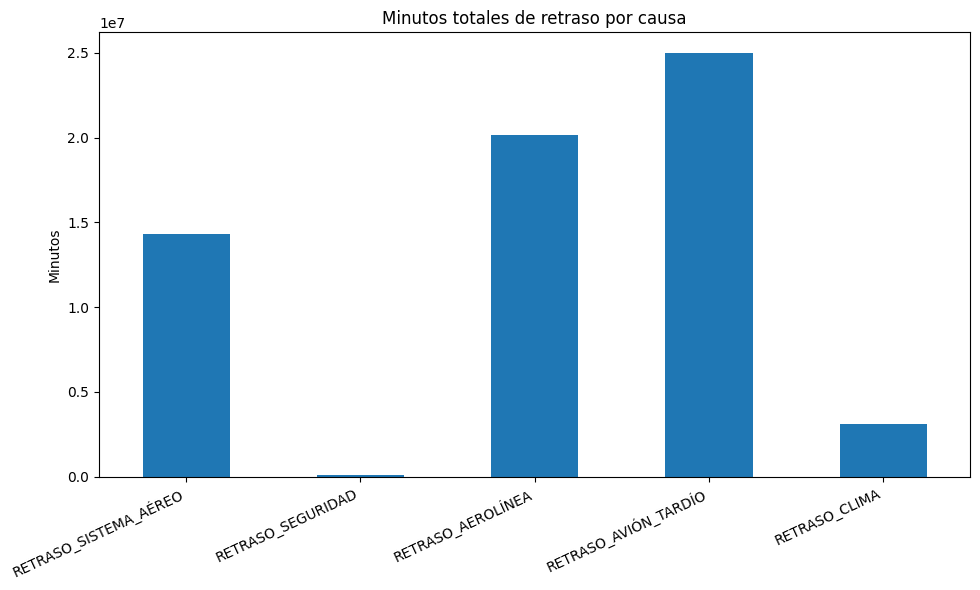

In [16]:
import matplotlib.pyplot as plt

causas = ['RETRASO_SISTEMA_AÉREO','RETRASO_SEGURIDAD',
          'RETRASO_AEROLÍNEA','RETRASO_AVIÓN_TARDÍO','RETRASO_CLIMA']

plt.figure(figsize=(10,6))
datos[causas].sum().plot(kind='bar')

plt.title("Minutos totales de retraso por causa")
plt.ylabel("Minutos")
plt.xticks(rotation=25, ha='right')  # Rotar etiquetas y alinearlas
plt.tight_layout()                   # Ajustar espacio para que no se corten

plt.savefig("Minutos_totales_de_retraso_por_causa.png", dpi=300)
plt.show()

##**Interpretación por rango de minutos de cada categoría de retraso**

📊 **Comparación de magnitudes**
| Categoría de retraso | Rango en minutos | Interpretación |
|----------------------|------------------|----------------|
|Puntualidad aceptada  | 0–15 | Normal, sin impacto significativo |
|Retraso leve  |16–30  | Aún tolerable, frecuente en operaciones |
|Retraso moderado  |31–60  | Ya afecta conexiones y logística |
| Retraso grave |  >60| Impacto fuerte en pasajeros y aerolínea |
|Retraso extremo|>180|Casos excepcionales, suelen implicar compensaciones|






#**Análisis de las variables que explican el retraso de avión tardío**

🔄 **Relación entre variable que explican el RETRASO_AVIÓN_TARDÍO.**

- Un RETRASO_LLEGADA positivo puede provocar que el avión llegue tarde al aeropuerto de origen.
- Ese mismo avión necesita tiempo para desembarcar pasajeros, cargar combustible, embarcar nuevos pasajeros y realizar rodaje, puede generar un RETRASO_SALIDA positivo en su siguiente vuelo desde el aeropuerto de origen.
- Es el famoso efecto cascada (RETRASO_AVIÓN_TARDÍO): un retraso en llegada se transmite como retraso en salida.


🔎 **Ejemplo práctico**
Imagina un avión que debía salir a las 10:00:
- **Llega a la puerta a las 09:50, pero por problemas de embarque sale a las 10:20 →**
>- RETRASO_SALIDA = 20 min
>- RETRASO_AVIÓN_TARDÍO = 0 min (porque el avión estaba a tiempo, el retraso fue por otra causa).
- **Llega a la puerta a las 10:30 porque venía atrasado de otro vuelo →**
>- RETRASO_SALIDA = 30 min
>- RETRASO_AVIÓN_TARDÍO = 30 min (el retraso de salida se explica totalmente por la llegada tardía).
- **Llega a las 10:20 y además hay problemas de embarque hasta las 10:40 →**
>- RETRASO_SALIDA = 40 min
>- RETRASO_AVIÓN_TARDÍO = 20 min (solo parte del retraso se debe al avión tardío).


**Ahora, conceptualmente:**

- **RETRASO_AVIÓN_TARDÍO** no es una causa primaria, sino más bien un efecto acumulado.
Se refiere a los minutos de retraso que un vuelo hereda porque el avión llegó tarde de un vuelo anterior.
Ese retraso puede estar explicado por cualquiera de las otras causas:
> - **RETRASO_CLIMA** → si el vuelo anterior se demoró por tormenta.
> - **RETRASO_AEROLÍNEA** → si hubo problemas operativos o logísticos.
> - **RETRASO_SISTEMA_AÉREO** → congestión en el tráfico aéreo.
> - **RETRASO_SEGURIDAD** → inspecciones adicionales.

👉 En otras palabras: todos esos retrasos pueden alimentar el retraso del avión tardío, porque si un vuelo se demora por cualquiera de esas razones, el avión llega tarde y arrastra el retraso al siguiente vuelo.


# **Paso 1: Crear variable objetivo**

In [17]:
# - Convertir la columna a números.
# - Si encuentra valores no numéricos (ej. "No Aplica"), los transforma en NaN.

datos['RETRASO_SALIDA'] = pd.to_numeric(datos['RETRASO_SALIDA'], errors='coerce')

# - Los valores que eran "No Aplica" ahora se convierten en 0
# - Esto tiene sentido porque “No Aplica” significa que no hubo retraso

datos['RETRASO_SALIDA'] = datos['RETRASO_SALIDA'].fillna(0)

# - Marca con 1 los vuelos cuyo retraso de salida supera los 30 minutos.
# - Marca con 0 los vuelos puntuales o con retrasos menores.

datos['RETRASO_GRAVE'] = (datos['RETRASO_SALIDA'] > 30).astype(int)

**📌 Beneficios paso a paso**
- Convertir a números (pd.to_numeric)
- Los modelos de machine learning trabajan con valores numéricos, no con texto.
- Al transformar "No Aplica" en NaN, evitas errores y aseguras que la columna sea consistente.
- Rellenar NaN con 0 (fillna(0))
- "No Aplica" significa que no hubo retraso, por lo tanto asignar 0 es lógico.
- Esto evita que el modelo interprete esos casos como datos faltantes y los descarte.
- Crear la variable binaria RETRASO_GRAVE
- Definir explícitamente qué es un retraso grave (>30 minutos) convierte un valor continuo en una clase clara (0/1).
- Esto es fundamental para entrenar un modelo de clasificación (ej. XGBoost, CatBoost).
- El modelo aprende a distinguir entre vuelos puntuales y vuelos con retraso significativo.

**✨ Impacto en el modelo**
- Claridad: defines de manera inequívoca qué significa “retraso grave”.
- Consistencia: todos los vuelos tienen un valor válido (0 o 1), sin huecos ni ambigüedades.
- Entrenabilidad: el modelo puede aprender patrones de las causas de retraso que llevan a superar los 30 minutos.
- Interpretabilidad: luego se puede evaluar métricas como precisión, recall y F1 sobre una variable objetivo bien definida.

#**🌟 Resumen**
- Este preprocesamiento convierte datos mixtos y poco claros en una variable binaria robusta, lo que hace que el modelo sea más confiable, eficiente y fácil de interpretar.



#**Paso 2: Factores correlacionados con retrasos superiores a 30 minutos**

In [18]:
correlaciones = datos[['RETRASO_SISTEMA_AÉREO','RETRASO_SEGURIDAD','RETRASO_AEROLÍNEA',
                       'RETRASO_AVIÓN_TARDÍO','RETRASO_CLIMA','LLEGADA_PROGRAMA','RETRASO_GRAVE']].corr()
print(correlaciones['RETRASO_GRAVE'].sort_values(ascending=False))

RETRASO_GRAVE            1.000000
RETRASO_AVIÓN_TARDÍO     0.535315
RETRASO_AEROLÍNEA        0.389211
RETRASO_SISTEMA_AÉREO    0.248072
RETRASO_CLIMA            0.156599
LLEGADA_PROGRAMA         0.109532
RETRASO_SEGURIDAD        0.029881
Name: RETRASO_GRAVE, dtype: float64


**✨ Lectura**

- Consistencia absoluta: RETRASO_AVIÓN_TARDÍO y RETRASO_AEROLÍNEA son los más fuertes en todos los métodos.
- Diferencias: CatBoost amplifica el rol de SISTEMA_AÉREO y CLIMA, lo que sugiere que captura mejor interacciones no lineales.
- Ruido: SEGURIDAD y LLEGADA_PROGRAMA son irrelevantes en todos los enfoques.


In [19]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.4 MB/s eta 0:00:00


In [20]:
from catboost import CatBoostClassifier

#**Paso 3: "Pipeline de machine learning para clasificación de retrasos graves (XGBoost + CatBoost ensemble)"**

El pipeline completo incluye:

- Entrenamiento de **XGBoost y CatBoost** con las variables más fuertes: **RETRASO_AVIÓN_TARDÍO, RETRASO_AEROLÍNEA,    RETRASO_SISTEMA_AÉREO, RETRASO_CLIMA**.
> - Priorizar las dos variables clave (AVIÓN_TARDÍO y AEROLÍNEA).
> - Explorar interacciones con SISTEMA_AÉREO y CLIMA, que CatBoost detecta mejor.

- Creación del **ensemble (promedio de probabilidades)**. Esto suaviza las diferencias y equilibra recall y precisión.

- Evaluación final con el **umbral 0.6** (matriz de confusión + reporte).
- Exportación opcional de resultados.




/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:05:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


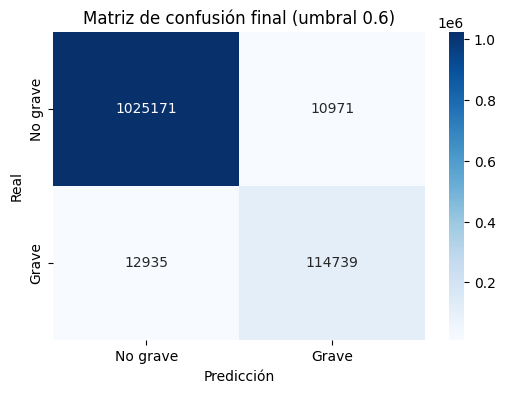

Reporte final con umbral 0.6:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1036142
           1       0.91      0.90      0.91    127674

    accuracy                           0.98   1163816
   macro avg       0.95      0.94      0.95   1163816
weighted avg       0.98      0.98      0.98   1163816



In [21]:
# --- Librerías principales ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Modelos ---
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# --- Utilidades ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ============================================================
# 1. Preparación de datos
# ============================================================
# Variables seleccionadas
X = datos[['RETRASO_AVIÓN_TARDÍO','RETRASO_AEROLÍNEA',
           'RETRASO_SISTEMA_AÉREO','RETRASO_CLIMA']]
y = datos['RETRASO_GRAVE']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# 2. Entrenamiento de modelos
# ============================================================

# --- XGBoost ---
xgb = XGBClassifier(
    scale_pos_weight=8.1,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train)

# --- CatBoost ---
cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)
cat.fit(X_train, y_train)

# ============================================================
# 3. Ensemble de probabilidades
# ============================================================
proba_xgb = xgb.predict_proba(X_test)[:,1]
proba_cat = cat.predict_proba(X_test)[:,1]

# Promedio de probabilidades
proba_ensemble = (proba_xgb + proba_cat) / 2

# ============================================================
# 4. Evaluación con umbral 0.6
# ============================================================
y_pred_final = (proba_ensemble >= 0.6).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No grave','Grave'],
            yticklabels=['No grave','Grave'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión final (umbral 0.6)")
plt.savefig("Matriz_de_confusión_final.png", dpi=300)
plt.show()

# Reporte de clasificación
print("Reporte final con umbral 0.6:")
print(classification_report(y_test, y_pred_final))

# ============================================================
# 5. Exportación opcional
# ============================================================
#resultados = pd.DataFrame({
#     "Real": y_test.values,
#     "Predicción": y_pred_final,
#     "Probabilidad": proba_ensemble
# })
#resultados.to_csv("predicciones_finales_umbral_06.csv", index=False)

In [30]:
datos.to_csv("flight_clean.csv", encoding="utf-8", index=False)

In [31]:
datos = pd.read_csv("flight_clean.csv", encoding="utf-8")

/tmp/ipython-input-1984518365.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  datos = pd.read_csv("flight_clean.csv", encoding="utf-8")


In [32]:
datos.columns = datos.columns.str.normalize("NFKD") \
                             .str.encode("ascii", errors="ignore") \
                             .str.decode("utf-8") \
                             .str.replace(" ", "_") \
                             .str.upper()
print(datos.columns)

Index(['ANO', 'MES', 'DIA', 'DIA_SEMANA', 'AEROLINEA', 'NUMERO_VUELO',
       'NUMERO_DEL_AVION', 'AEROPUERTO_ORIGEN', 'AEROPUERTO_DESTINO',
       'SALIDA_PROGRAMADA', 'HORA_SALIDA', 'RETRASO_SALIDA', 'RODAJE_SALIDA',
       'DESPEGUE', 'TIEMPO_PROGRAMADO', 'TIEMPO_TOTAL_REAL', 'TIEMPO_EN_AIRE',
       'DISTANCIA', 'ATERRIZAJE', 'RODAJE_LLEGADA', 'LLEGADA_PROGRAMADA',
       'HORA_LLEGADA', 'RETRASO_LLEGADA', 'DESVIADO', 'CANCELADO',
       'RAZON_CANCELACION', 'RETRASO_SISTEMA_AEREO', 'RETRASO_SEGURIDAD',
       'RETRASO_AEROLINEA', 'RETRASO_AVION_TARDIO', 'RETRASO_CLIMA',
       'LLEGADA_PROGRAMA', 'RETRASO_GRAVE'],
      dtype='object')
